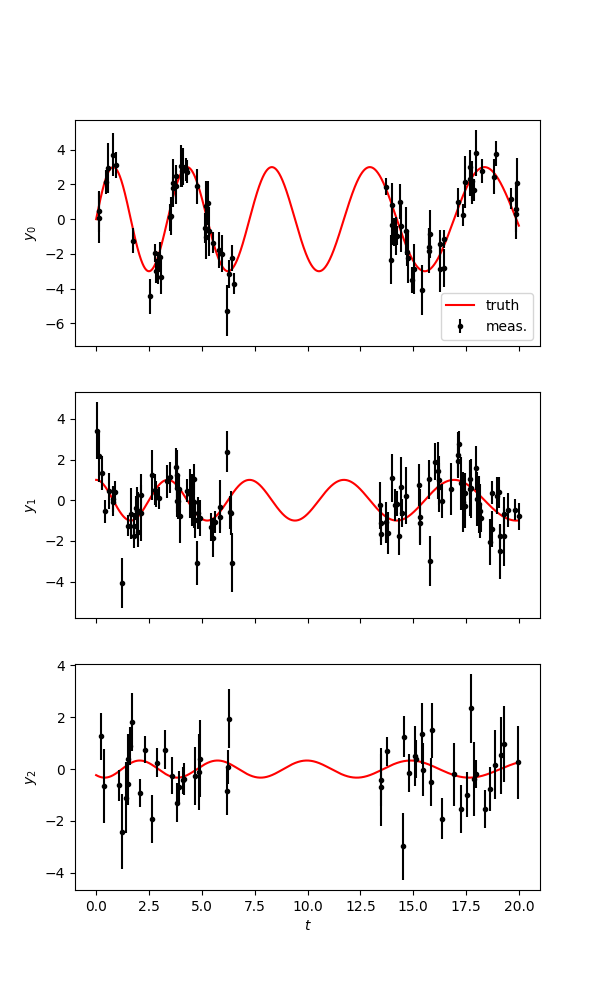

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

np.random.seed(0)

# Settings
P0 = 3.8
dP = 1.25
tmax = 20
amp = [3.0, 1.0, 0.33]
phase = [0, np.pi / 2, -3*np.pi / 4]
nt = [75, 100, 50]

# True signal
tsmooth = np.linspace(0, tmax, 2000)
Psmooth = P0 + dP * (tsmooth / tmax - 1 / 2)
Ysignal = [
  ak * np.sin(2 * np.pi * tsmooth / Psmooth + pk)
  for ak, pk in zip(amp, phase)
]

# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 3,
  ntk // 2), np.random.uniform(2 * tmax / 3, tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
P = [P0 + dP * (tk / tmax - 1 / 2) for tk in T]
Y = [
  amp[k] * np.sin(2 * np.pi * T[k] / P[k] + phase[k]) +
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

In [3]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)


In [4]:
print(t_full)
print(y_full)
print(series_index)

[ 0.03130317  0.12526534  0.13405031  0.13478932  0.21225953  0.26125195
  0.38686107  0.42764998  0.47357372  0.580862    0.62627007  0.78849617
  0.79151813  0.80131041  0.87865242  0.95568858  1.09796104  1.22127575
  1.24128671  1.39895833  1.48721088  1.49283125  1.51609752  1.58595214
  1.65835429  1.69570988  1.76370408  1.76926327  1.80005315  1.88537975
  1.92937395  1.97426798  1.98291301  2.0796333   2.11988786  2.12379302
  2.30234454  2.55627679  2.64337161  2.65480708  2.7617533   2.76441293
  2.82436533  2.82570032  2.89611084  2.91724808  2.98083586  3.04100221
  3.07652908  3.26972539  3.34216255  3.47898881  3.48832036  3.52596613
  3.57088535  3.63255455  3.65875669  3.77734303  3.78696374  3.78955966
  3.81501271  3.8396433   3.8410489   3.84819059  3.87515248  3.91008623
  3.93273318  3.94694621  4.01842251  4.08063815  4.09310637  4.11756998
  4.14318934  4.26614014  4.29326799  4.30596075  4.44940253  4.51877691
  4.6164808   4.61687727  4.66319517  4.69609601  4

In [52]:
# Initialize the S+LEAF model
C = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.SHOKernel(1.0, 5.0, 1.0), series_index,
  np.ones(3), np.ones(3)))

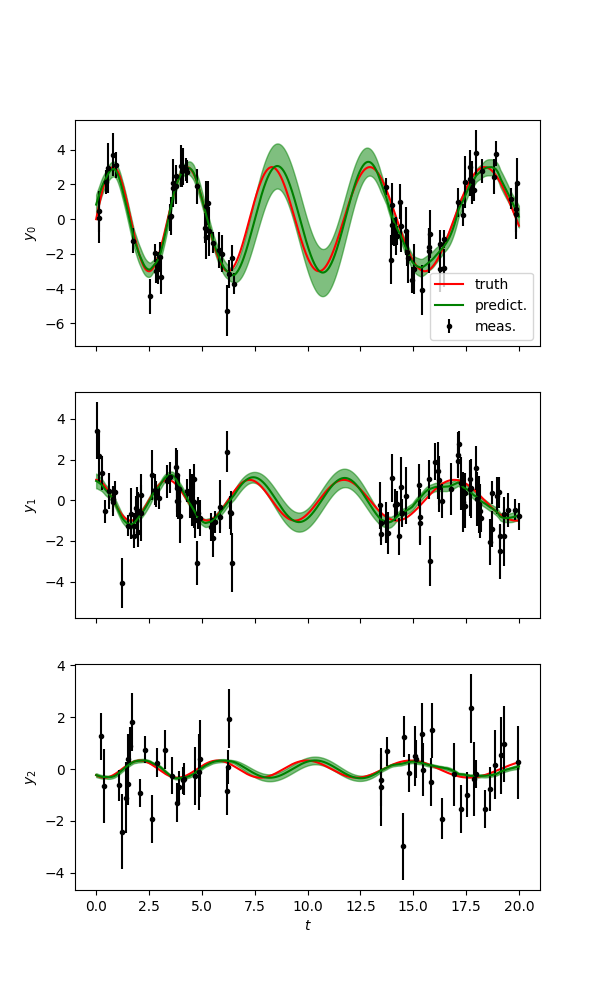

In [53]:

# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# List of parameters to fit
param = C.param[1:]
# The amplitude of the SHOKernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.

# Define the function to minimize
def negloglike(x, y, C):
  C.set_param(x, param)
  nll = -C.loglike(y)
  # gradient
  nll_grad = -C.loglike_grad()[1][1:]
  return (nll, nll_grad)

# Fit
xbest, _, _ = fmin_l_bfgs_b(negloglike, C.get_param(param), args=(y_full, C))

# Use S+LEAF to predict the missing data
C.set_param(xbest, param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu, var = C.conditional(y_full, tsmooth, calc_cov='diag')

  # Plot
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu - np.sqrt(var),
    mu + np.sqrt(var),
    color='g',
    alpha=0.5)
  ax.plot(tsmooth, mu, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()